Dad Joke Filter
Goal: Make a filter for my dad that can predict if a joke of his is funny
This Notebook: Filter jokes based off of his type, remove mispellings, and create a binary classifcation datset containing funny and not funny jokes

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle

import warnings
warnings.filterwarnings('ignore')

# custom functions
from utils import *
from jupyterthemes import jtplot
jtplot.style()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Read-in and explore the dataset

In [2]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [3]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [4]:
df.shape

(1000000, 12)

In [5]:
pd.options.display.max_colwidth = None
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [6]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


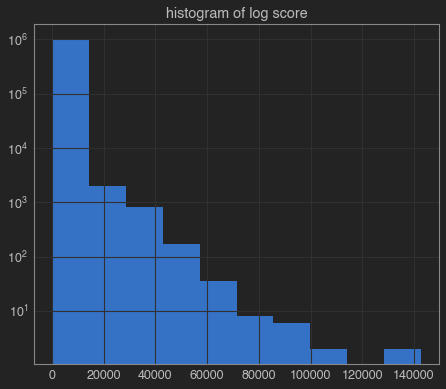

In [7]:
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [8]:
# define some parameters 
CLASS_SIZE = 100000
TRAIN_SIZE = 0.95
MIN_UPVOTES = 50
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 200
SELFTEXT_MAX_LEN = 200

In [9]:
# boolean masks

# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.lower() == '[removed]') | (df['title'].str.lower() == '[removed]')

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.lower() == '[deleted]') | (df['title'].str.lower() == '[deleted]')

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [10]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated]
df_cleaned.shape

(565688, 12)

In [11]:
# what are nans?
df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10) 

,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [12]:
df_cleaned = df_cleaned[~is_null]

In [13]:
# removing edits
PATTERN = r"(?<![a-z])(e|E)(d|D)(i|I)(t|T)\W.+"
df_cleaned['title'] = df_cleaned['title'].apply(lambda x: re.sub(PATTERN, "", x))
df_cleaned['selftext'] = df_cleaned['selftext'].apply(lambda x: re.sub(PATTERN, "", x))

In [14]:
# Filter entries that are short, but meet other necessary criteria

# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# generate lengths of each string's instance
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['title'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 0) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 0) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

359829 samples match


In [15]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(sub)?(reddit)|\S(vote)s?|(\sop\s)"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
df_cleaned[is_meta].sample(30)[['title', 'selftext', 'score']]

,title,selftext,score
178965,Which is the oldest living animal in the world ???,"A zebra,... Coz it's black and white 🦓. How many downvotes am I gonna get for this shit (\_(\ ( -.- ) o_("")("")",0
650244,A new subreddit for people who are only slightly into wrestling,mildyintowrestling,13
125501,[Politics] Joke Advice: Don’t make Hillary Clinton jokes in this subreddit.,"They’re not funny. Rather, they’re hillary-ious.",10
18684,What do you get when you cross a redditor with,A society that abandons him and treats him like trash?,4
316123,What's a Redditor's favourite fencing technique?,The riposte.,26
865223,awesome jokes guys keep em coming,"As a single father, I love browsing this subreddit so when I see my wifes kids once a month I have a lot of epic jokes to tell them. Keep em coming!",0
610477,A punchline walks into a bar...,"The bartender looks at it and says ""This is /r/jokes we don't accept your kind here.""",9
409511,What did Batman say to Robin before they got in the car?,"STOP WITH YOUR DANG /R/ANTIJOKES! GOD FORBID, YOU'RE ON /R/JOKES. TELL SOMETHING FUNNY AT LEAST! MAKE IT A REPOST IF YOU GOTTA. YOU USLESS IDIOT. THIS IS WHY I BECAME THE RED HOOD...",4
818690,TIFU by subscribing to the wrong subreddit,"Oops, wrong subreddit.",1
69520,"I'm trying to guess Mick Jagger's reddit username, and I'm getting close.",It's just a stone's throwaway.,3


In [16]:
df_cleaned = df_cleaned[~is_meta]

In [17]:
# offensive jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\srape\w)|(\sanal\s)|(\snigger\s)|(\sblack people\s)|(\sblack man\s)|(cock\s)|(\spussy\s)|(\scunt\s)|(\sgay\s)"
is_offensive = df_cleaned['title'].str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.contains(PATTERN, regex=True)
df_cleaned[is_offensive].sample(30)[['title', 'selftext', 'score']]

,title,selftext,score
634510,What is ironic about black people working in police ammunition factories,They have a high chance of being killed with a bullet that they made,0
339313,Brussels Sprouts are like anal sex,"If you’re forced to have it has a kid, you probably won’t enjoy it as an adult.",0
675758,If I had a dollar for every racist thing I'd said,A black man would rob me.,0
198739,Tucker Carlson really puts the Aryan into Libertarian. I'm not saying he's a Nazi...,"But he definitely refers to anal sex as ""entering the gas chamber""",0
649740,Where do gay guys get their taxes done?,H&amp;R **Cock**,0
677007,"Regular sex will make your day,",but anal sex will make your hole weak.,75
491946,How do you tell if there's a Russian at a cock fight?,He brings the orange How can you tell if there's Russian Mafia at the cockfight? He bets on the orange How can you tell if Putin is at the cockfight? The orange wins,18
795502,"A black man walks into the ""No lights"" club.","Bartender shouts ""Hey! Who left the door open!?""",0
170951,I would tell a gay joke but...,I faggot it,0
609728,Explicit: How do you get 4 gay guys on a chair,"You put the chair upside down (I have nothing against gays, just a good joke)",0


In [18]:
df_cleaned = df_cleaned[~is_offensive]

In [19]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

maximum sampling size is 96033
 proceeding with this value...
***** calculating *****
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 100000
current size 48472


### Make the positive and negative class labels and concatenate the dataframe

          count         mean        std   min   25%    50%    75%       max
target                                                                     
False   48472.0     0.000000     0.0000   0.0   0.0    0.0    0.0       0.0
True    48472.0  1340.361157  4881.4334  51.0  81.0  155.0  432.0  136359.0
Saving figure class distribution after cleaning


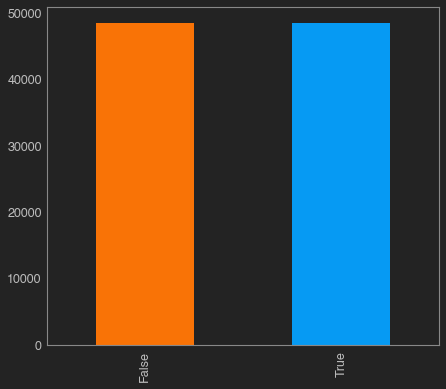

In [20]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
print(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

### Split into train / test data

In [21]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat)).reset_index(drop=True)

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)
pd.to_pickle(train, "./data/train.pkl")
pd.to_pickle(test, "./data/test.pkl")

(92096, 15) (4848, 15)


## Explore the Data

In [22]:
# some useful boolean masks
is_funny = train['target'] == True

In [23]:
# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
6546,My first highschool football game was a lot like my first time having sex...,"I was pretty roughed up, sore, and kinda bloody, but at least my dad came (:",1247
72047,"All these people getting emails from the Prince of Nigeria, I got one from an Egyptian Pharaoh...",But it turned out to just be a pyramid scheme.,1637
92033,Met a beautiful girl down at the park today..,"Met a beautiful girl down at the park today. Sparks flew, she fell at my feet and we ended up having sex right there and then. God, I love my new Taser...",4840
5022,Someone said my clothes were gay,"I said ""Yeah, they came out of the closet this morning.""",2730
44083,"As an Aussie, Americans are always asking me where in Australia there ""isn't"" something trying to kill you....","""School"" is my answer.",38015
80876,A local barber was arrested for selling drugs. I've been his customer for 5 years,I never knew he was a barber,3815
40468,Why was the Pepsi employee fired?,He tested positive for coke.,1611
70934,"Well, you won't get called a racist for criticizing the President anymore...",...you'll just get called a racist for supporting him.,1096
53762,I got arrested the other day for holding a little girl's hand,They wanted to know where the rest of her body was,828
35820,What does Melania call it when Donald takes Viagra?,A rigged erection.,793


In [24]:
# examples of not funny jokes
train[train['score'] == 0][['title', 'selftext']].sample(10)

,title,selftext
38536,...got rid of dwarf boyfriend!,...he was always poking his nose in!
27914,-Are you always this funny?,-Just long enough to get to fuck you
67192,"Yo, can you pass me the Aux cord?","Nah man, I just have the cow cord."
55225,A guy walks into a bar,"And says, 'Damn that hurt'"
23904,Garb flarb bjarb...,HARB CAR!
26685,What do you call it when Donald Trump pretends to sleep?,Fake snooze
82601,I tried to join a club for people who can fell a tree with a single stroke...,But I didn't make the cut.
61668,It's really frustrating when you run out of pirate jokes.,Arr
52904,How did they know Christa McAuliffe had dandruff?,They found her head and shoulders on the beach
58621,My niece was the victim of demonic possession FOR THE SECOND TIME.,She was repossessed.


Saving figure density plot of log title length


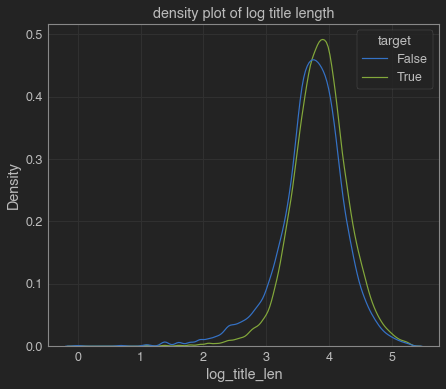

Saving figure density plot of log selftext length


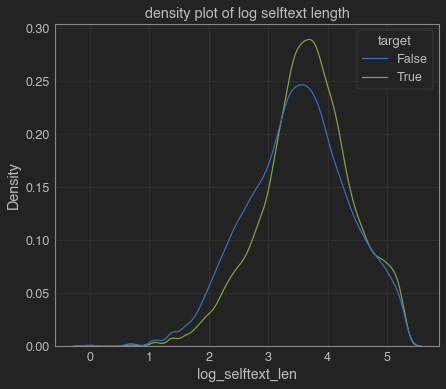

In [25]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()


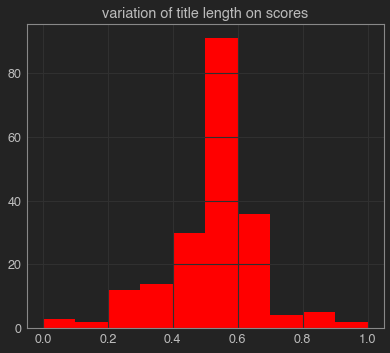

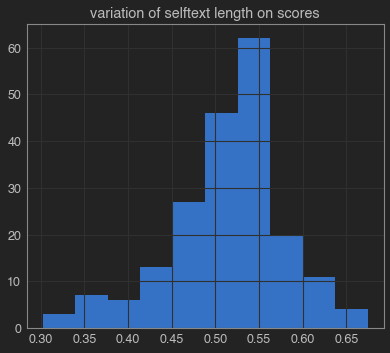

In [26]:
train.groupby(['title_len']).mean()['target'].hist(color='red')
plt.title('variation of title length on scores')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores')
plt.show()

### Examine Time Series Data

In [27]:
# making unix created_times into readable timestamps
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].set_index('created_at', drop=True).sort_index()
df_not_funny = train[~is_funny].set_index('created_at', drop=True).sort_index()

Saving figure submissions over time


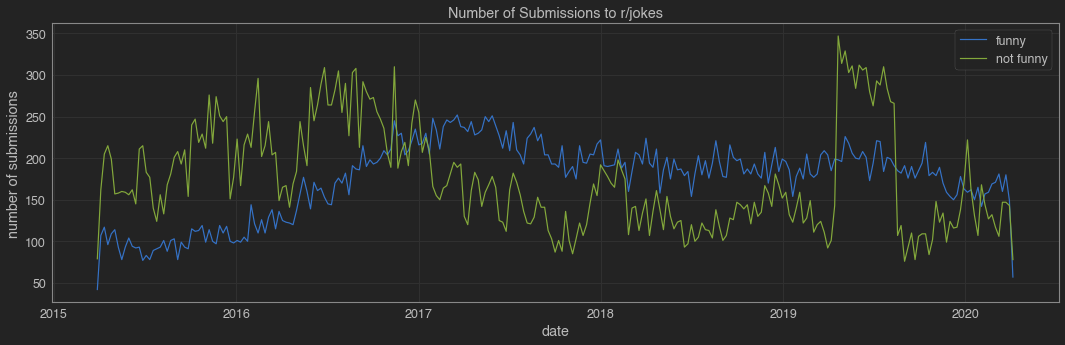

In [28]:
# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

Saving figure average submission per hour


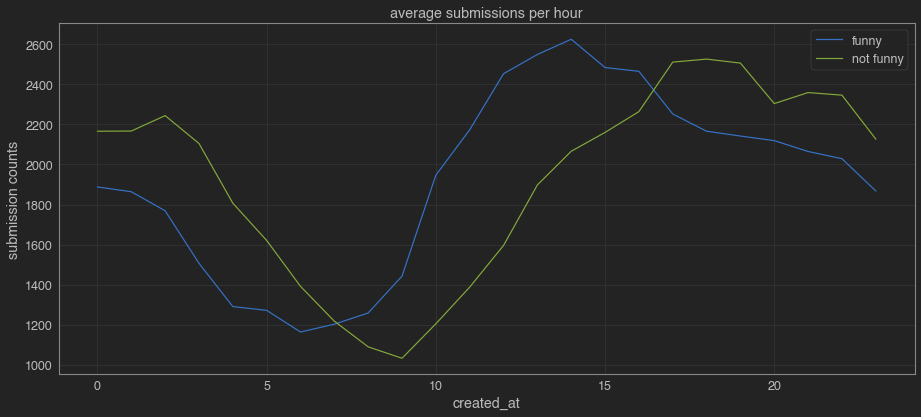

In [29]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

<AxesSubplot:xlabel='created_at', ylabel='type'>

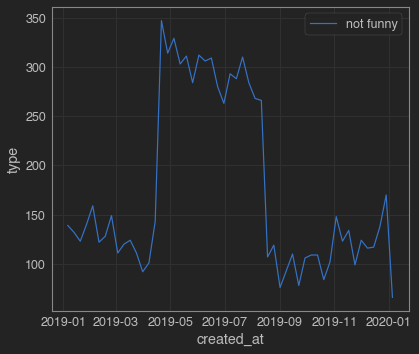

In [30]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')

In [31]:
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date.date()), str(end_date.date())
print(f'dates of anomaly: {start_date_not_funny_event} - {end_date_not_funny_event}')

dates of anomaly: 2019-04-07 - 2019-09-01
